# Classifiez automatiquement des biens de consommation

## Objectifs

- Faisabilité :
    - réaliser une première étude de faisabilité d'un moteur de classification
    - analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering.
    - démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie\
        1. Faire pour le texte :
        - deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf
        - une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
        - une approche de type word/sentence embedding avec BERT ;
        - une approche de type word/sentence embedding avec USE (Universal Sentence Encoder)
        - utiliser comme point de départ, cela va te faire gagner beaucoup de temps\
        2. Faire pour les images :
        - un algorithme de type SIFT / ORB / SURF ;
        - un algorithme de type CNN Transfer Learning

## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import tensorflow as tf
import tensorflow_hub as hub

import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Import du dataframe

In [2]:
data_all = pd.read_csv("./Flipkart/flipkart_com-ecommerce_sample_1050.csv")
data_all.sample(5)

uniq_id            crawl_timestamp  \
892  6858fd9265d348803b18667fe43cd054  2015-12-20 08:26:17 +0000   
842  de47d0cc0c4875fb97530f66d934c894  2015-12-29 05:07:38 +0000   
934  43da6e88dcb61e027ea9112cfab158ee  2016-01-01 13:15:34 +0000   
910  23b0bdd337f7d1b4b70ad13726a122ab  2016-04-02 19:26:28 +0000   
41   a79117ea49a0533f641facdb4c99f502  2016-06-15 04:53:12 +0000   

                                           product_url  \
892  http://www.flipkart.com/mb-cotton-set-towels/p...   
842  http://www.flipkart.com/kliqvik-six-port-usb-h...   
934  http://www.flipkart.com/aurraa-printed-single-...   
910  http://www.flipkart.com/beebay-baby-boy-s-chec...   
41   http://www.flipkart.com/kripa-s-printed-cushio...   

                                          product_name  \
892                            MB Cotton Set of Towels   
842  KLIQVIK SIX PORT USB HUB FOR SAMSUNG MOBILES T...   
934    Aurraa Printed Single Quilts & Comforters Green   
910           Beebay Baby Boy's Checkered Casual Shirt   
41                      Kripa's Printed Cushions Cover   

                                 product_category_tree               pid  \
892        ["Home Furnishing >> Bath Linen >> Towels"]  BTWEYFA942QUCJ6Q   
842  ["Computers >> Laptop Accessories >> USB Gadge...  USGEDZF2UQ38HTJ5   
934  ["Home Furnishing >> Bed Linen >> Blankets, Qu...  BLAEEDJ6GGYYASSR   
910  ["Baby Care >> Infant Wear >> Baby Boys' Cloth...  SHTEFGG5HZYKCFTT   
41   ["Home Furnishing >> Kripa's Home Furnishing >...  CPCEJMHZEHTQFACN   

     retail_price  discounted_price                                 image  \
892        1495.0            1195.0  6858fd9265d348803b18667fe43cd054.jpg   
842        1499.0            1099.0  de47d0cc0c4875fb97530f66d934c894.jpg   
934        2399.0            1425.0  43da6e88dcb61e027ea9112cfab158ee.jpg   
910         845.0             845.0  23b0bdd337f7d1b4b70ad13726a122ab.jpg   
41          500.0             400.0  a79117ea49a0533f641facdb4c99f502.jpg   

     is_FK_Advantage_product  \
892                    False   
842                    False   
934                    False   
910                    False   
41                     False   

                                           description       product_rating  \
892  Buy MB Cotton Set of Towels at Rs. 1195 at Fli...                  3.5   
842  Buy KLIQVIK SIX PORT USB HUB FOR SAMSUNG MOBIL...  No rating available   
934  Aurraa Printed Single Quilts & Comforters Gree...  No rating available   
910  Specifications of Beebay Baby Boy's Checkered ...  No rating available   
41   Key Features of Kripa's Printed Cushions Cover...  No rating available   

          overall_rating    brand  \
892                  3.5       MB   
842  No rating available  KLIQVIK   
934  No rating available   Aurraa   
910  No rating available   Beebay   
41   No rating available  Kripa's   

                                product_specifications  
892  {"product_specification"=>[{"key"=>"Material",...  
842  {"product_specification"=>[{"key"=>"Brand", "v...  
934  {"product_specification"=>[{"key"=>"Machine Wa...  
910  {"product_specification"=>[{"key"=>"Pattern", ...  
41   {"product_specification"=>[{"key"=>"Brand", "v...

In [3]:
data_all.shape

(1050, 15)

In [4]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

On voit assez rapidement où sont les colonnes importantes : product_name et description sont les colonnes à clusteriser, "product_category_tree" est la colonne y de référence pour la classification

## Catégories et sous catégories

La colonne product_category_tree contient des catégories principales et secondaires, on va les séparer.

In [5]:
data_all['categorie_principale']=data_all['product_category_tree'].str.slice(2).str.split('>>').str[0]
data_all['categorie_principale'].nunique()

7

In [6]:
data_all['categorie_secondaire']=data_all['product_category_tree'].str.slice(2).str.split('>>').str[1]
data_all['categorie_secondaire'].nunique()

63

## Fonction de nettoyage des colonnes textuelles

In [7]:
# Tokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2 and not (w.isnumeric() or (any(c.isdigit() for c in w) and any(c.isalpha() for c in w)))]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.endswith(".com"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_all['description_bow'] = data_all['description'].apply(lambda x : transform_bow_fct(x))
data_all['description_bow_lem'] = data_all['description'].apply(lambda x : transform_bow_lem_fct(x))
data_all['description_dl'] = data_all['description'].apply(lambda x : transform_dl_fct(x))
data_all['product_category_tree_bow'] = data_all['product_category_tree'].apply(lambda x : transform_bow_fct(x))
data_all['product_category_tree_bow_lem'] = data_all['product_category_tree'].apply(lambda x : transform_bow_lem_fct(x))
data_all['product_category_tree_dl'] = data_all['product_category_tree'].apply(lambda x : transform_dl_fct(x))
data_all['product_name_bow'] = data_all['product_name'].apply(lambda x : transform_bow_fct(x))
data_all['product_name_bow_lem'] = data_all['product_name'].apply(lambda x : transform_bow_lem_fct(x))
data_all['product_name_dl'] = data_all['product_name'].apply(lambda x : transform_dl_fct(x))
data_all.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuel.martin.67/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manuel.martin.67/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manuel.martin.67/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/manuel.martin.67/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(1050, 26)

In [8]:
print(data_all['description_bow_lem'].sample(10))

919    buy anjalika brass laddu gopal showpiece onlin...
9      tag heuer formula analog watch for boy men buy...
903    key feature brandwagon digiprint digital repri...
76     specification gift box stor jewellary vanity j...
267    sahara shop kadhai stainless steel price premi...
731    specification tidy green cotton kitchen linen ...
277    key feature palito plo analog watch for girl w...
662    hargunz polyester brown white motif eyelet lon...
540    time sport analog watch for boy buy time sport...
296    specification ball ibctdc dual core ram hard d...
Name: description_bow_lem, dtype: object


## Tokénisation

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_all['length_description_bow'] = data_all['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length description bow : ", data_all['length_description_bow'].max())
data_all['length_description_dl'] = data_all['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length description dl : ", data_all['length_description_dl'].max())

data_all['length_product_category_tree_bow'] = data_all['product_category_tree_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length product_category_tree bow : ", data_all['length_product_category_tree_bow'].max())
data_all['length_product_category_tree_dl'] = data_all['product_category_tree_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length product_category_tree dl : ", data_all['length_product_category_tree_dl'].max())

data_all['length_product_name_bow'] = data_all['product_name_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length product_name bow : ", data_all['length_product_name_bow'].max())
data_all['length_product_name_dl'] = data_all['product_name_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length product_name dl : ", data_all['length_product_name_dl'].max())

max length description bow :  371
max length description dl :  614
max length product_category_tree bow :  25
max length product_category_tree dl :  46
max length product_name bow :  21
max length product_name dl :  34


## Bag of word avec T-SNE et comparaison avec la première catégorie

In [10]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    fig.suptitle('Analyse via t-SNE', fontsize=16)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num,cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat,
              loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [11]:
l_cat = list(set(data_all['categorie_principale']))
print("catégories : ", l_cat)
print("nombre de catégories : ",len(l_cat))
y_cat_num = [(l_cat.index(data_all.iloc[i]['categorie_principale'])) for i in range(len(data_all))]

catégories :  ['Home Furnishing ', 'Beauty and Personal Care ', 'Watches ', 'Computers ', 'Baby Care ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ']
nombre de catégories :  7


### En utilisant uniquement la colonne description

In [12]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

In [13]:
feat = 'description_bow_lem'
cv_fit = cvect.fit(data_all[feat])
ctf_fit = ctf.fit(data_all[feat])

cv_transform = cvect.transform(data_all[feat])  
ctf_transform = ctf.transform(data_all[feat]) 

In [14]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.3839 time :  6.0

Tf-idf : 
--------
ARI :  0.485 time :  6.0


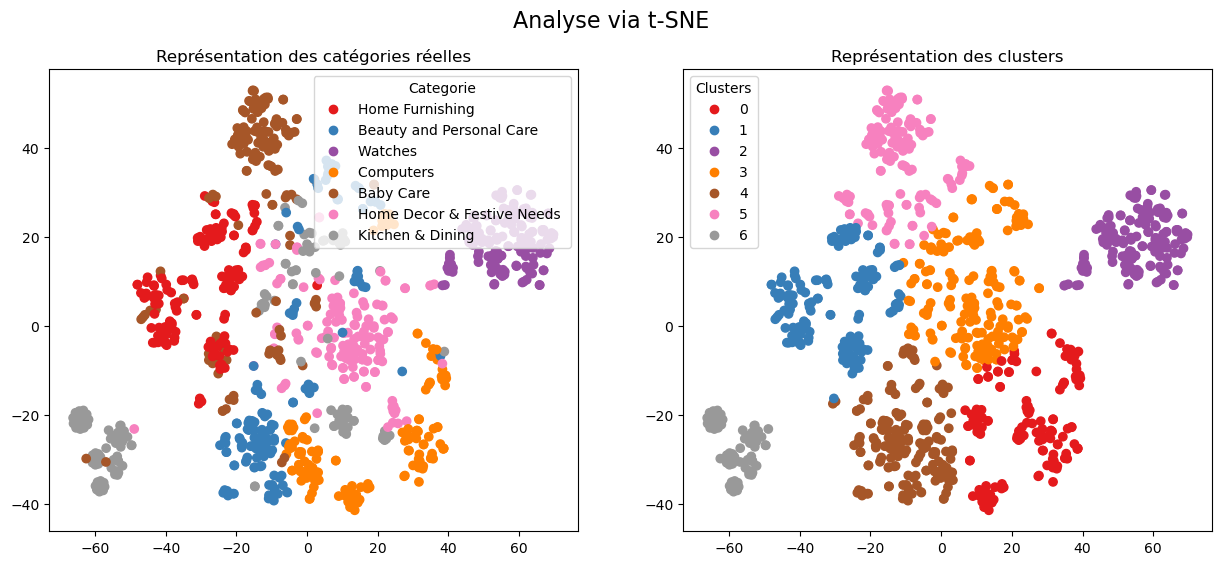

ARI :  0.485


In [15]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

En utilisant un bag of word sur la description, on obtient un ARI de 0,47 par rapport aux catégories initiales

### En utilisant uniquement la colonne product_name

In [16]:
feat = 'product_name_bow_lem'
cv_fit = cvect.fit(data_all[feat])
ctf_fit = ctf.fit(data_all[feat])

cv_transform = cvect.transform(data_all[feat])  
ctf_transform = ctf.transform(data_all[feat]) 

In [17]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3541 time :  6.0

Tf-idf : 
--------
ARI :  0.321 time :  6.0


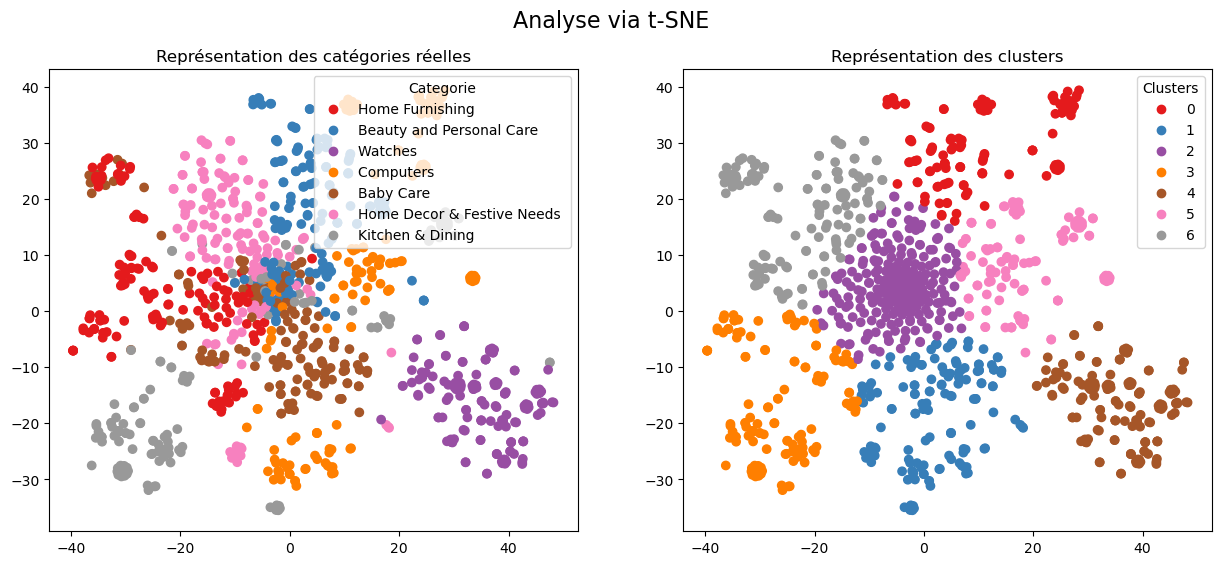

ARI :  0.321


In [18]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

En utilisant un bag of word sur le product name, on obtient un ARI de 0,38 par rapport aux catégories initiales

### En utilisant uniquement les colonnes description + product_name

In [19]:
data_all['description_product_name_bow_lem'] = data_all['description_bow_lem'].str.cat(data_all['product_name_bow_lem'],sep=' ')
data_all['description_product_name_dl'] = data_all['description_dl'].str.cat(data_all['product_name_dl'],sep=' ')

In [20]:
feat = 'description_product_name_bow_lem'
cv_fit = cvect.fit(data_all[feat])
ctf_fit = ctf.fit(data_all[feat])

cv_transform = cvect.transform(data_all[feat])  
ctf_transform = ctf.transform(data_all[feat]) 

In [21]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.4236 time :  6.0

Tf-idf : 
--------
ARI :  0.6023 time :  6.0


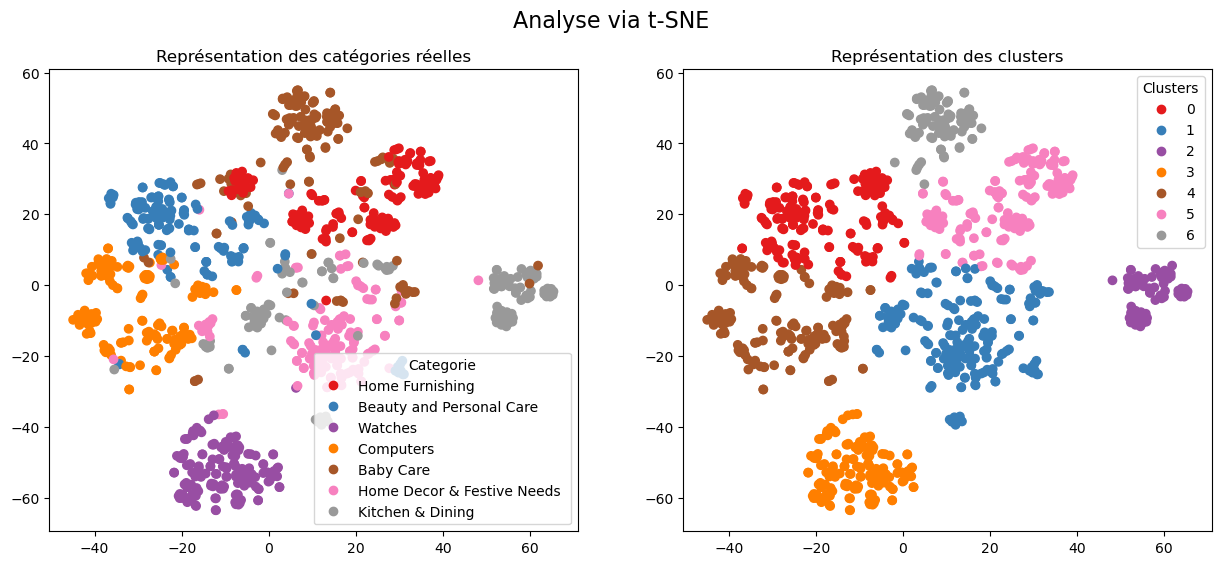

ARI :  0.6023


In [22]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

En utilisant un bag of word sur le product name et la description, on obtient un ARI de 0,57 par rapport aux catégories initiales.

### Bag of word final

In [23]:
feat1 = 'description_product_name_bow_lem'
cv_fit = cvect.fit(data_all[feat1])
ctf_fit = ctf.fit(data_all[feat1])

feat2 = 'description_product_name_bow_lem'
cv_transform = cvect.transform(data_all[feat2])  
ctf_transform = ctf.transform(data_all[feat2]) 

In [24]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.4236 time :  6.0

Tf-idf : 
--------
ARI :  0.6023 time :  5.0


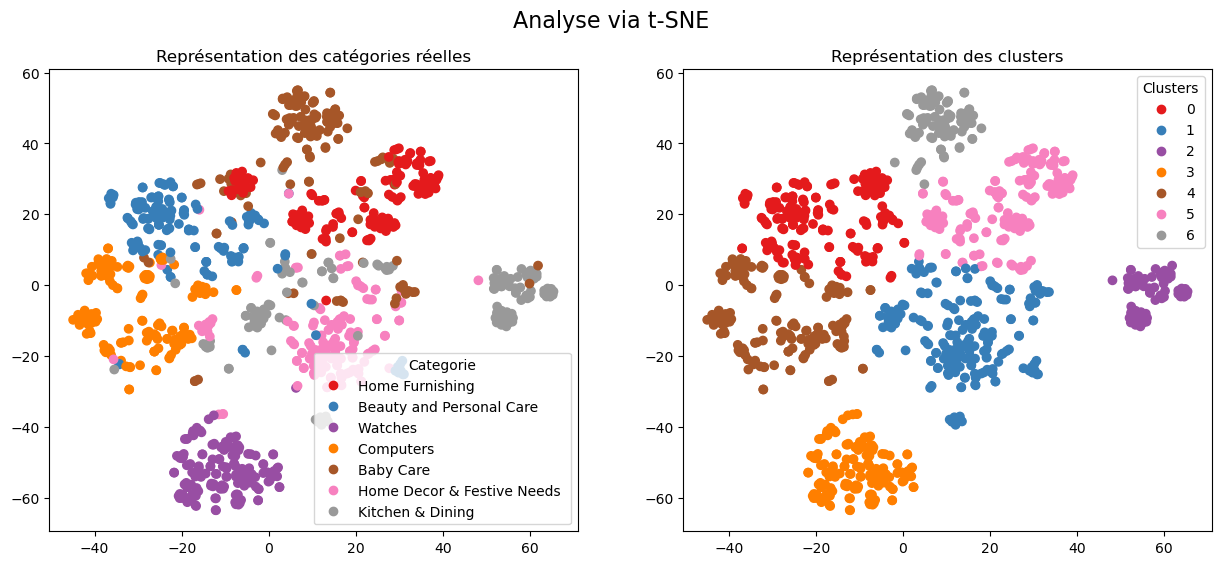

ARI :  0.6023


In [25]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### ACP

In [26]:
from sklearn.decomposition import PCA

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_PCA_fct(features) :
    features_df = features.toarray()
    time1 = time.time()
    num_labels=len(l_cat)
       
    # application de la PCA
    pca = PCA()
    X_pca= pca.fit_transform(features_df)
        
    # Détermination des clusters à partir des données après PCA 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_pca)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_pca, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def PCA_visu_fct(X_pca, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    fig.suptitle('Analyse via PCA', fontsize=16)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_pca[:,0],X_pca[:,1], c=y_cat_num,cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat,
              loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_pca[:,0],X_pca[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [27]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_pca, labels = ARI_PCA_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_pca, labels = ARI_PCA_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.1825 time :  8.0

Tf-idf : 
--------
ARI :  0.2514 time :  11.0


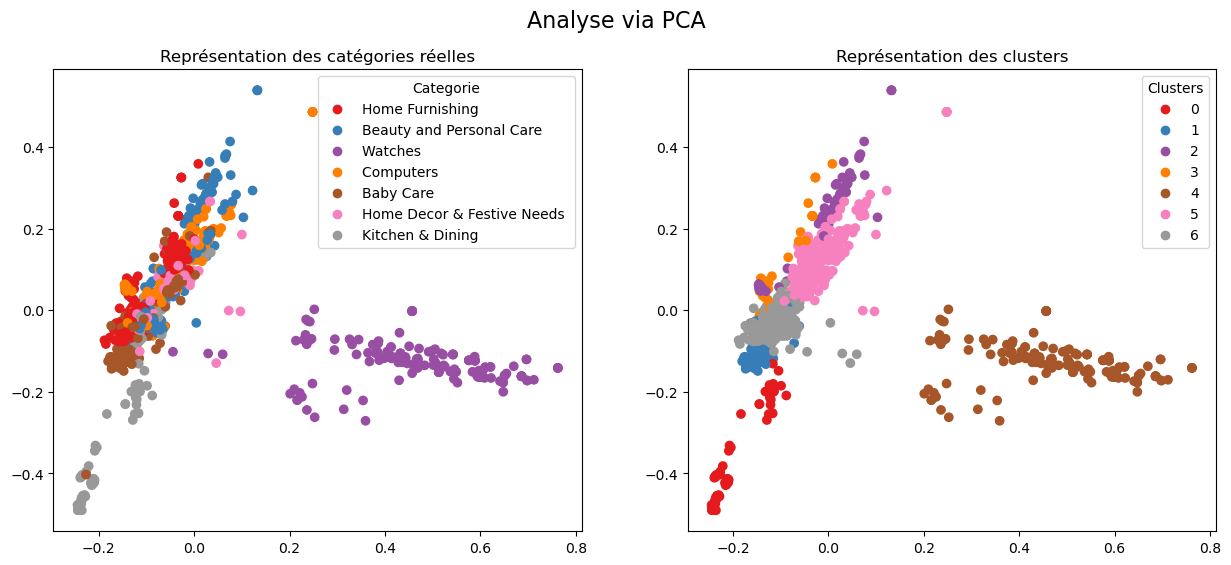

ARI :  0.2514


In [28]:
PCA_visu_fct(X_pca, y_cat_num, labels, ARI)

### Latent Dirichlet Allocation

In [32]:

from sklearn.decomposition import LatentDirichletAllocation

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_LDA2_fct(features) :
    features_df = features.toarray()
    time1 = time.time()
    num_labels=len(l_cat)
    LDA = LatentDirichletAllocation(n_components=num_labels)
    X=features_df
    X_lda = LDA.fit_transform(X)
        
    # Détermination des clusters à partir des données après LatentDirichletAllocation 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_lda)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_lda, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def LDA2_visu_fct(X_lda, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(16,7))
    fig.suptitle('Analyse via LDA', fontsize=16)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_lda[:,0],X_lda[:,1], c=y_cat_num ,cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_lda[:,0],X_lda[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [33]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_lda, labels = ARI_LDA2_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_lda, labels = ARI_LDA2_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.2512 time :  2.0

Tf-idf : 
--------
ARI :  0.1744 time :  1.0


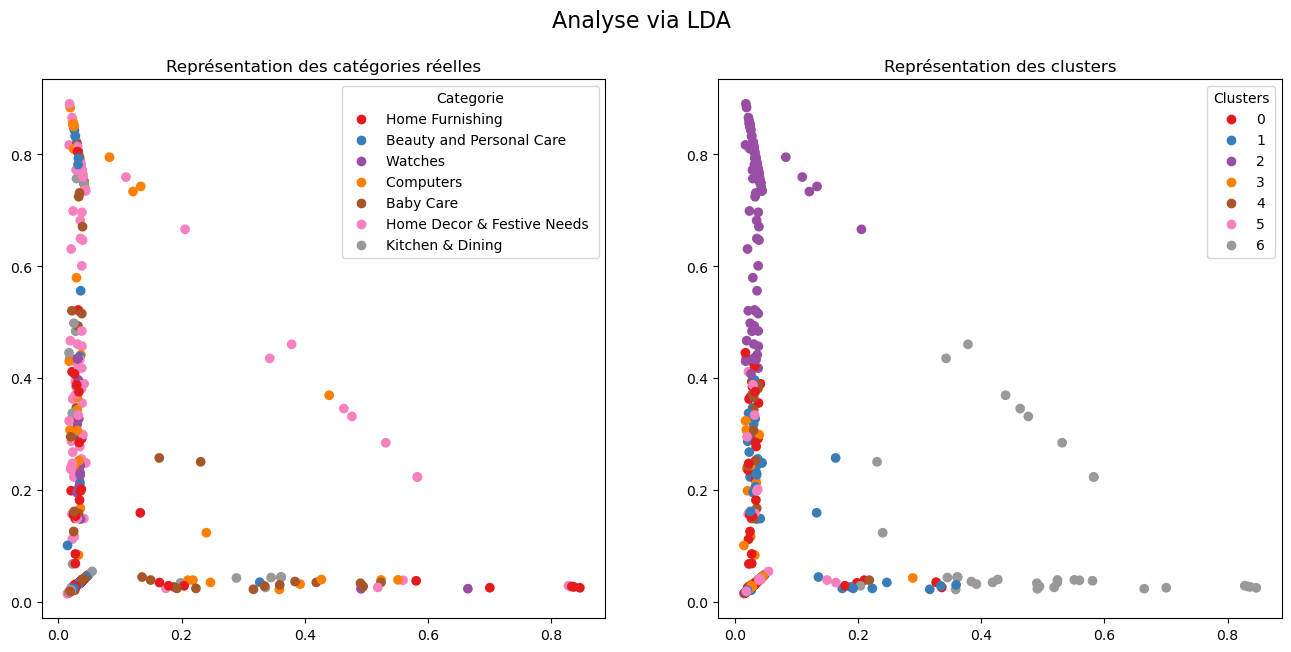

ARI :  0.1744


In [34]:
LDA2_visu_fct(X_lda, y_cat_num, labels, ARI)

## Même clusterings mais avec les catégories secondaires

In [35]:
l_cat = list(set(data_all['categorie_secondaire']))
print("catégories : ", l_cat)
print("nombre de catégories : ",len(l_cat))
y_cat_num = [(l_cat.index(data_all.iloc[i]['categorie_secondaire'])) for i in range(len(data_all))]

catégories :  [' Candles & Fragrances ', ' Housekeeping & Laundry ', ' Computer Peripherals ', ' Baby & Kids Gifts ', ' Pressure Cookers & Pans ', ' Consumables & Disposables ', ' Bed Linen ', ' Living ', ' Flowers, Plants & Vases ', ' Eye Care ', ' Clocks ', " Men's Grooming ", ' Furniture & Furnishings ', ' Diapering & Potty Training ', ' Bath and Spa ', ' Bar & Glassware ', ' Wall Decor & Clocks ', ' Living"]', ' Showpiece ', ' Tidy Home Furnishing ', " Women's Hygiene ", ' Wrist Watches ', ' Tablet Accessories ', ' Kitchen Tools ', ' Showpieces ', ' Baby Bedding ', ' Cushions, Pillows & Covers ', ' JMD Home Furnishing ', ' Body and Skin Care ', ' Dinnerware & Crockery ', ' Beauty Accessories ', ' Religion & Devotion ', ' Software ', ' Bath Linen ', ' Network Components ', ' Baby Grooming ', ' Laptops ', ' Baby Bath & Skin ', ' TRUE Home Decor & Festive Needs"]', ' Decorative Lighting & Lamps ', ' Containers & Bottles ', ' Garden & Leisure ', ' Coffee Mugs ', ' Storage ', ' Laptop A

### T-SNE

In [36]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.2967 time :  7.0

Tf-idf : 
--------
ARI :  0.3124 time :  6.0


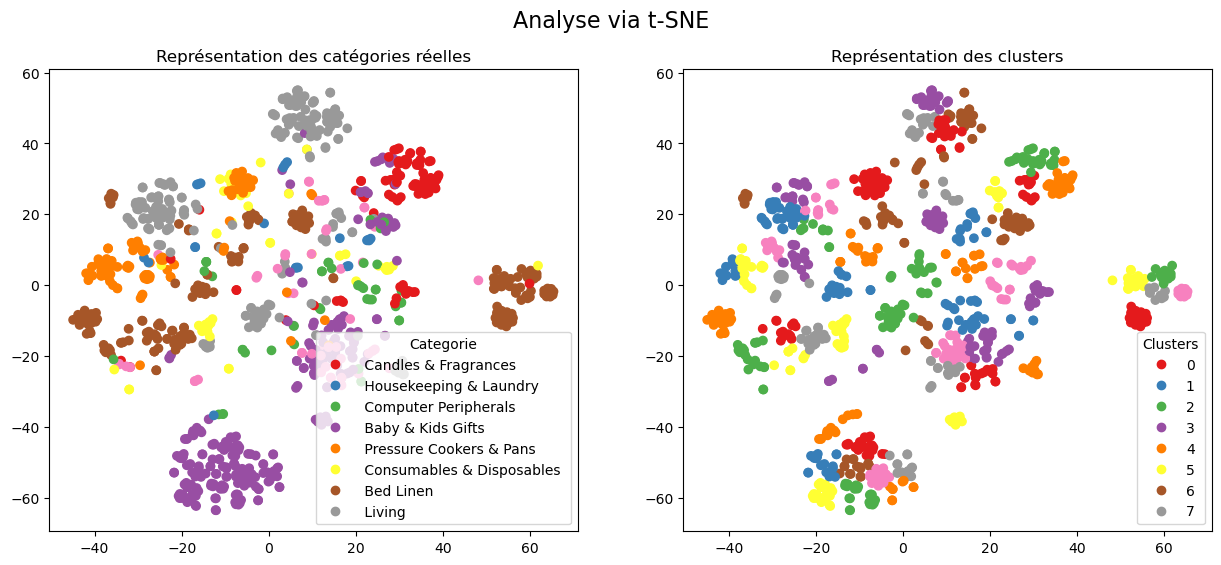

ARI :  0.3124


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### ACP

In [38]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_pca, labels = ARI_PCA_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_pca, labels = ARI_PCA_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.2511 time :  26.0

Tf-idf : 
--------
ARI :  0.3275 time :  25.0


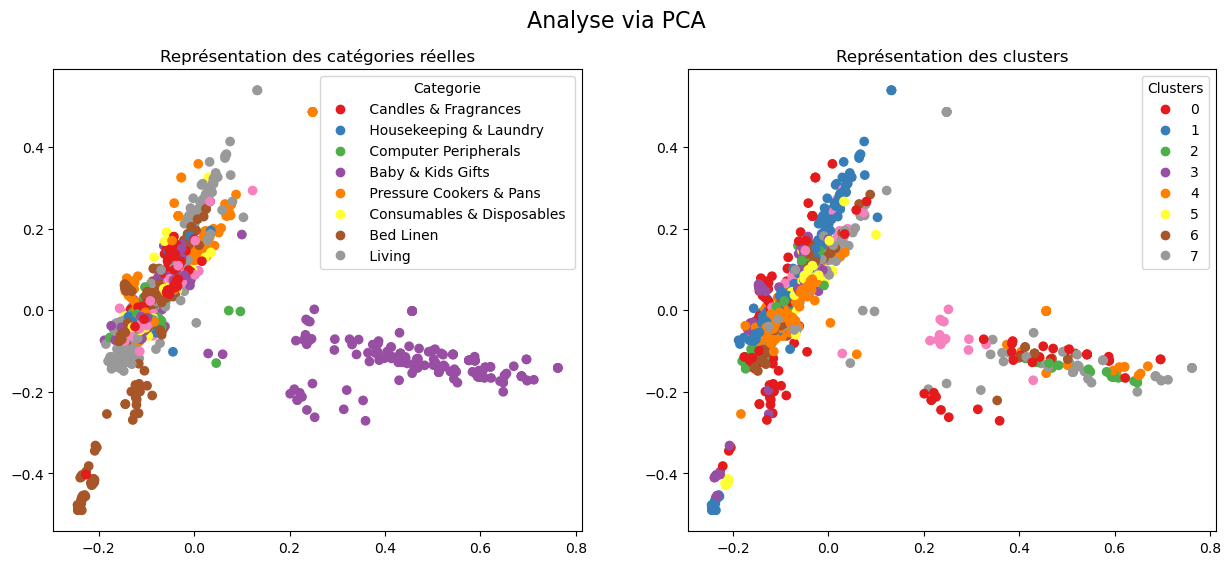

ARI :  0.3275


In [39]:
PCA_visu_fct(X_pca, y_cat_num, labels, ARI)

### Latent Dirichlet Allocation

In [42]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_lda, labels = ARI_LDA2_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_lda, labels = ARI_LDA2_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.2989 time :  7.0

Tf-idf : 
--------
ARI :  0.2973 time :  4.0


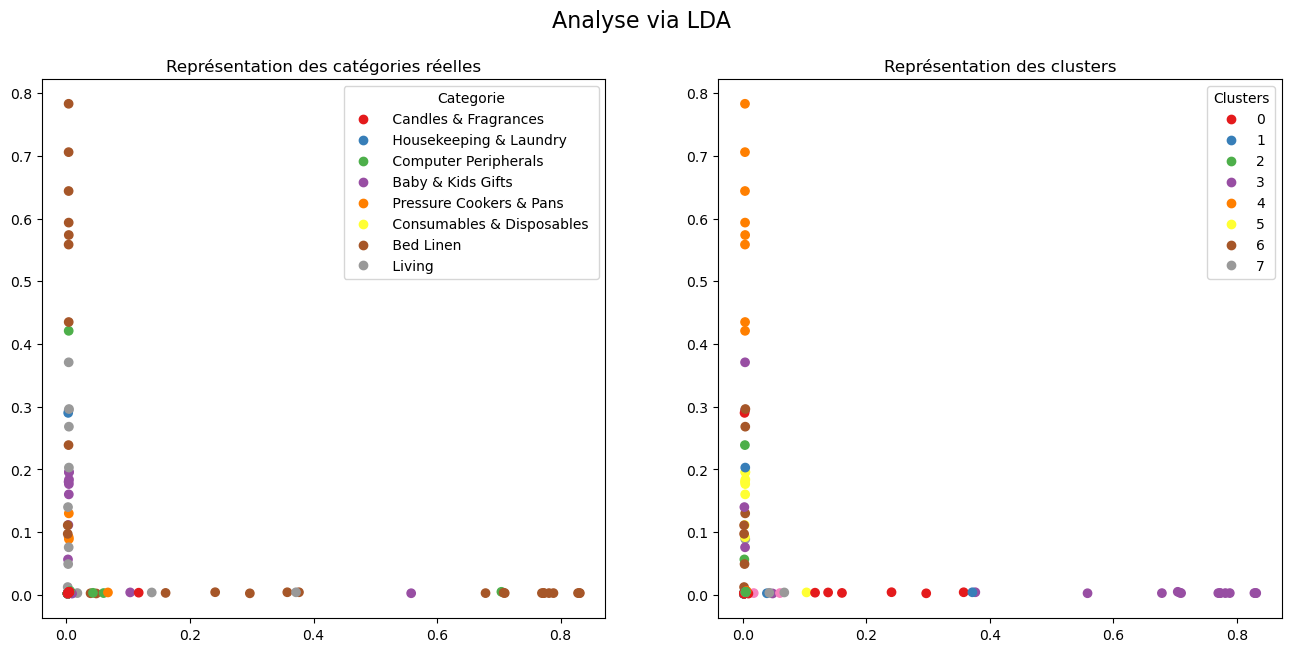

ARI :  0.2973


In [43]:
LDA2_visu_fct(X_lda, y_cat_num, labels, ARI)

## Word2Vec

Les plongements de mots sont des représentations vectorielles d'un mot dans un espace vectoriel de dimensions réduites, qui capturent les relations sémantiques et syntaxiques entre les mots. Les plongements de mots sont souvent utilisés comme entrées pour les modèles de traitement du langage naturel (NLP) pour améliorer leur performance.\
L'algorithme Word2Vec repose sur l'hypothèse distributionnelle, qui stipule que les mots qui apparaissent dans des contextes similaires ont des significations similaires. Word2Vec utilise deux approches pour apprendre les plongements de mots: la méthode Skip-gram et la méthode CBOW (Continuous Bag-of-Words). La méthode Skip-gram vise à prédire les mots voisins à partir d'un mot d'entrée, tandis que la méthode CBOW vise à prédire un mot d'entrée à partir de ses voisins. Les deux méthodes sont implémentées dans la classe gensim.models.Word2Vec et peuvent être utilisées en fonction des besoins de l'utilisateur.

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [45]:
l_cat = list(set(data_all['categorie_principale']))
print("catégories : ", l_cat)
print("nombre de catégories : ",len(l_cat))
y_cat_num = [(l_cat.index(data_all.iloc[i]['categorie_principale'])) for i in range(len(data_all))]

catégories :  ['Home Furnishing ', 'Beauty and Personal Care ', 'Watches ', 'Computers ', 'Baby Care ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ']
nombre de catégories :  7


### Compréhension du code du Word2Vec
Pour essayer de comprendre ce code, je vais partir de la fin, pour revenir sur le sens de chaque étape.

Après avoir remonter le fil, voilà le résumé de ma compréhension :
- On crée d'abord les vecteurs de plongements pour tout le vocabulaire du corpus
- Ensuite on tokenize le corpus pour avoir un corpus tokénizé
- On crée ensuite la matrice de plongement, qui crée un vecteur pour tous le mots du corpus. Attention elle peut etre différente de la premiere étape si on décide de ne pas prendre tous les mots du corpus dans gensim.
- On crée notre modèle de transfert learning, on lui attribuant les poids de chaque mot suivant la matrice de plongement.
- On applique ce modèle sur notre corpus tokenizé.
- On obtient au final un corpus, avec pour chaque phrase un vecteur de 300 paramètres.
- On applique un tSNE et un Kmeans pour créer les clusters, et on compare aux catégories réelles.

### Création du modèle Word2Vec

In [46]:
sentences_bow_lem = data_all['description_product_name_bow_lem'].to_list()
sentences_bow_lem = [gensim.utils.simple_preprocess(text) for text in sentences_bow_lem] #pretraitement du texte de chaque phrase

data_all['lentgh_description_product_name_bow_lem'] = data_all['description_product_name_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max description_product_name_bow_lem : ", data_all['lentgh_description_product_name_bow_lem'].max())

maxlen = 375 # adapt to length of sentences

max description_product_name_bow_lem :  375


In [47]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=1, window=5, vector_size=300, seed=42, workers=1) # definition du modèle
w2v_model.build_vocab(sentences_bow_lem) #construction du vocabulaire
w2v_model.train(sentences_bow_lem, total_examples=w2v_model.corpus_count, epochs=100) #entrainement du modèle
model_vectors = w2v_model.wv # enregistrement de la collection de vecteurs de mots
w2v_words = model_vectors.index_to_key #enregistrement du vocabulaire
print("Vocabulary size: %i" % (len(w2v_words)+1))
print("Taille des vecteurs :", model_vectors.vector_size)
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4457
Taille des vecteurs : 300
Word2Vec trained


C'est ici que l'on va créé les vecteurs de plongement pour chaque mot du vocabulaire.

On va d'abord définir un modèle Word2Vec de gensim :
- min_count va regarder le minimum d'apparition des mots
- window va regarder le nombre de mots autour du mot analysé
- vector_size sera la taille du vecteur
- seed pour gérer l'aléatoire
- workers le nombre de cpu à l'oeuvre

On va ensuite construire le vocabulaire avec notre corpus, puis on va entrainer le modèle.

Ensuite on enregistre sous model_vectors la liste des vecteurs pour chaque mot du vocabulaire. C'est cette matrice que l'on utilisera pour créer la matrice de plongement.

In [48]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer() #définition du tokenizer
tokenizer.fit_on_texts(sentences_bow_lem) #entrainement sur le corpus
# Conversion des phrases du corpus en séquences d'entiers
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences_bow_lem), #conversion des phrases du corpus en séquences d'entier
                            maxlen=maxlen, padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4457


Ici on s'attarde sur la tokenization du corpus.

On définit d'abord un tokenizer.\
On l'entraine ensuite sur le corpus, pour qu'il puisse attribuer un entier à chaque mot du corpus.\
Puis il transforme les phrases en une séquence d'entiers, ceux attribué aux mots par le tokenizer.\
Enfin "pad_sequences" s'occupe de compléter la matrice en complétant les blancs.

C'est donc cette matrice qui sera utilisée dans le modèle final.

In [49]:
x_sentences.shape

(1050, 375)

### Création de la matrice d'embedding

In [50]:
# Création de la matrice d'embedding

# Créer une matrice d'embedding pour les mots
print("Créer la matrice d'embedding...")
# Taille de l'embedding
w2v_size = model_vectors.vector_size
# Obtenir l'index de chaque mot du corpus
word_index = tokenizer.word_index
# Nombre total de mots dans le vocabulaire
vocab_size = len(word_index) + 1
# Initialiser une matrice de zéros pour stocker les embeddings
embedding_matrix = np.zeros((vocab_size, w2v_size))
# Initialiser des variables pour compter le nombre total de mots et le nombre de mots pour lesquels on a un embedding
i=0
j=0
    
# Parcourir chaque mot du vocabulaire
for word, idx in word_index.items():
    i +=1
    # Vérifier si le mot a un embedding
    if word in w2v_words:
        j +=1
        # Obtenir l'embedding du mot
        embedding_vector = model_vectors[word]
        # Ajouter l'embedding de ce mot à la matrice d'embedding si disponible
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
# Calculer le taux de mots avec embeddings par rapport au nombre total de mots
word_rate = np.round(j/i,4)
print("Taux d'embedding des mots : ", word_rate)
print("Forme de la matrice d'embedding: %s" % str(embedding_matrix.shape))

Créer la matrice d'embedding...
Taux d'embedding des mots :  1.0
Forme de la matrice d'embedding: (4457, 300)


Ici on s'attarde sur la création de la matrice d'embedding, qui nous sert à initialiser la couche d'embedding dans le modèle suivant.
- On crée une matrice de zeros, de taille (nb de mots dans le vocab) x (taille des vecteurs)
- pour tous les mots du tokenizer, on regarde s'il a un vecteur de plongement
- si le mot a un vecteur de plongement, on l'enregistre dans la matrice
- s'il n'a pas de vecteur de plongement, on laisse sa ligne à zero
- enfin on verifie le taux de remplissage de cette matrice, pour voir quelle est la proportion de mots avec plongement

In [51]:
# Création du modèle

# Création de la couche d'entrée pour les mots
word_input=Input(shape=(maxlen,),dtype='float64')  

# Création de la couche d'embedding pour les mots en utilisant l'embedding_matrix et une taille de vecteur d'embedding w2v_size de 300
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)

# GlobalAveragePooling1D permet de faire une moyenne sur les vecteurs de chaque mot dans la séquence pour avoir une représentation vectorielle unique
word_vec=GlobalAveragePooling1D()(word_embedding)  

# Création du modèle avec l'entrée de la couche word_input et la sortie de la couche word_vec
embed_model = Model([word_input],word_vec)

# Affichage du résumé du modèle
embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 375)]             0         
                                                                 
 embedding (Embedding)       (None, 375, 300)          1337100   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,337,100
Trainable params: 1,337,100
Non-trainable params: 0
_________________________________________________________________


Ici on comprend que "embed_model" est issu de Model([word_input],word_vec). Suivant la doc de TF, Model regroupe les couches dans un objet avec des fonctions d'apprentissage et d'inférence. Il prend en argument des 'inputs' (à comprendre comme une couche en entrée sur le modèle), des 'outputs' (à comprendre comme une couche en sortie sur le modèle) et un 'name'.\
Les arguments "[word_input]" et "word_vec" nous indique que le modèle prend comme couche en entrée Input(shape=(375,),dtype='float64'), qui est utilisé pour instancier un tenseur de Keras :
- "shape=(375,)" nous dit que l'entrée attendue sera constituée de lots de vecteurs à 375 dimensions de réels.

Et en sortie une couche Embedding qui transforme les entiers positifs (index) en vecteurs denses de taille fixe, suivie d'une couche GlobalAveragePooling1D qui est une couche de mutualisation de la moyenne globale des données temporelles.\
Au niveau des arguments de la couche d'embedding (celle qui nous interesse le plus) :
- input_dim, la taille du vocabulaire, qui s'appelle ici "vocab_size"
- output_dim, le nombre de paramètres pour chaque vecteur, ici model_vectors.vector_size
- weights = [embedding_matrix], "embedding_matrix" est utilisée pour initialiser les poids de la couche d'embedding. Chaque ligne de cette matrice représente le vecteur d'embedding d'un mot unique dans le vocabulaire.
- input_length, la longueur des entrées soit 375

Pour résumé, on a les étapes suivantes :
1. En entrée des phrases de longueur 375 max
2. Embedding de ces phrases individuellement
3. Moyenne des vecteurs de chaque phrase pour n'avoir plus qu'une seul vecteur


### Exécution du modèle


In [52]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


2023-04-03 09:23:19.476749: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(1050, 300)

Ici on comprend que "embeddings" est la prédiction de "embed_model" de "x_sentences". On comprend que "embed_model" est un modèle entrainé (surement le modèle qui sert à faire le plongement de mots), et que "x_sentences" sont les données d'entrées (probablement les phrases).

In [53]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.3685 time :  5.0


Avec cette étape, on comprend que "embeddings" est équivalent à "ctf_transform" du bag of word. C'est une matrice de 1050 textes, exprimés par des vecteurs de 300 features. Toutes les étapes précédentes servent donc à créer cette matrice.

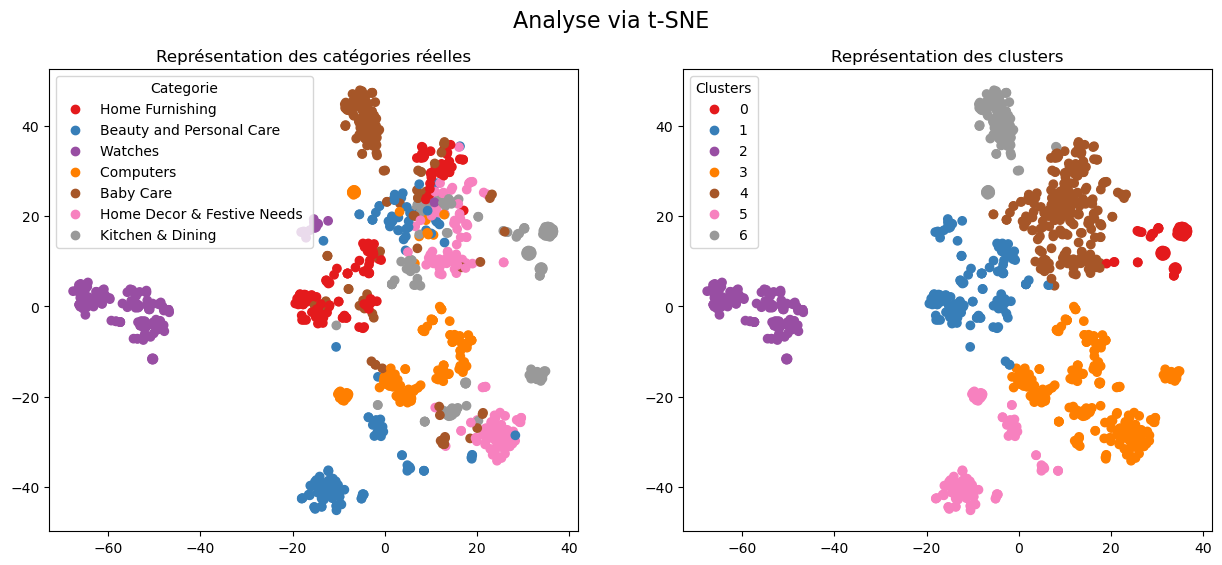

ARI :  0.3685


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT

BERT (Bidirectional Encoder Representations from Transformers) est un modèle de langage pré-entraîné développé par Google en 2018. Il est basé sur une architecture de réseaux de neurones de type transformer et a été formé en utilisant un objectif d'apprentissage non supervisé de type MLM (Masked Language Modeling) et de prédiction de la phrase suivante.


Contrairement à d'autres modèles de langage tels que GPT (Generative Pre-trained Transformer) qui ne prennent en compte que les contextes précédents pour prédire les prochains mots, BERT utilise les contextes précédents et suivants pour prédire le mot masqué. Cela permet à BERT de mieux comprendre les relations entre les mots et les phrases, ainsi que de capturer des connaissances contextuelles plus complexes.

Le modèle BERT est constitué d'une architecture de réseaux de neurones de type transformer avec des couches d'encodage et de décodage. Les couches d'encodage capturent les relations entre les différents éléments de la séquence d'entrée, tandis que les couches de décodage permettent de générer une sortie à partir de l'état caché final.

BERT est pré-entraîné sur un vaste corpus de données non annotées, tels que des articles de journaux et des livres. Ce processus d'entraînement prend généralement plusieurs jours sur des clusters de GPU ou TPU et permet au modèle de capturer une compréhension profonde des structures linguistiques et des relations entre les mots.

Après l'entraînement, le modèle BERT peut être utilisé pour effectuer des tâches de traitement du langage naturel (NLP) telles que la classification de texte, l'étiquetage de séquence, la traduction de langue, la réponse aux questions, etc. En utilisant des techniques de fine-tuning (affinage), le modèle peut être adapté pour des tâches spécifiques avec un ensemble de données étiquetées plus petit.

BERT a été un point de référence majeur dans le domaine de NLP, car il a permis de réaliser des performances supérieures dans de nombreuses tâches de NLP en utilisant une seule architecture de modèle. Depuis sa sortie, de nombreuses variantes de BERT ont été développées pour résoudre des problèmes spécifiques tels que RoBERTa, ALBERT et DistilBERT.

In [55]:
from transformers import *

## Fonctions communes


In [56]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    # Initialisation des listes pour stocker les entrées BERT
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    # Pour chaque phrase
    for sent in sentences:
        # Encodage de la phrase en utilisant le tokenizer BERT
        bert_inp = bert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_length,
                                              padding='max_length', return_attention_mask = True, 
                                              return_token_type_ids=True, truncation=True, return_tensors="tf")
    
        # Ajout des entrées encodées aux listes correspondantes
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    # Conversion des listes en tableaux numpy
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    # Retourne les entrées encodées et les listes complètes pour chaque phrase
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

La sous fonction bert_inp_fct est ici décrite.

Elle prend en entrée :
- sentences qui est la liste des phrases du corpus.
- bert_tokenizer qui est le tokenizer à utiliser dans cette fonction
- max_length est la longueur des phrases à tokeniser.

Pour chaque phrase elle réalise une tokenization. Elle utilise la librairie "transformers" pour cela.\
Cela renvoie plusieurs informations :
- input_ids est l'entier identifiant le mot, à savoir le token
- token_type_ids est utilisé pour savoir si les phrases sont à analyser deux à deux, ou en question réponse.
- attention_mask est utilisé pour savoir où se trouve les mots, lorsque les phrases ne font pas la même longueur.

La fonction finit par compiler toutes ces tokenizations, et retourne également un tableau numpy avec toutes les infos réunies.

In [57]:
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    # Initialisation des variables
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        # Appel de la fonction bert_inp_fct pour préparer les données BERT
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size],
                                                                                 bert_tokenizer, max_length)
        # Utilisation de BERT avec HuggingFace
        if mode == 'HF':
            # Utilisation du modèle pour faire une prédiction sur les données d'entrée
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            # Récupération des derniers états cachés
            last_hidden_states = outputs.last_hidden_state

        # Utilisation de BERT avec Tensorflow Hub
        if mode == 'TFhub':
            # Préparation des données en un dictionnaire compréhensible pour le modèle
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            # Utilisation du modèle pour faire une prédiction sur les données d'entrée
            outputs = model(text_preprocessed)
            # Récupération des derniers états cachés
            last_hidden_states = outputs['sequence_output']

        # Concaténation des derniers états cachés sur toutes les étapes
        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))

    # Calcul de la moyenne des derniers états cachés
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    # Calcul du temps d'exécution de la fonction
    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

La fonction "feature_BERT_fct" est ici détaillée.

Elle prend en variable en entrée model, model_type, sentences, max_length, b_size, mode='HF'
- model est utilisé pour définir quel modèle sera utilisé pour les prédictions
- model_type est utilisé pour définir le tokenizer utilisé dans la fonction
- sentences est utilisé dans la sous fonction "bert_inp_fct" que nous verrons après
- max_length est utilisé dans la sous fonction "bert_inp_fct" que nous verrons après
- b_size est utilisé pour définir la taille de lot du traitement du modèle
- mode est utilisé pour savoir si le modèle sera de type "HuggingFace" ou "Tensorflow Hub"

Elle fonctionne par lot.\
D'abord la fonction prépare les données à l'aide de la sous fonction "bert_inp_fct".\
Ensuite elle fait la prédiction des données de sortie en fonction du modèle.\
Elle prend ensuite la dernière prédiction effectuée grace à ".last_hidden_state"\
Elle compile toutes les prédictions, et en fait la moyenne à fin pour obtenir les outputs de la fonction, à savoir :
- features_bert qui est la matrice du corpus transformée
- last_hidden_states_tot qui est la même matrice, mais sans faire de moyenne. Je ne sais pas pourquoi elle sort, je pense qu'on pourrait l'enlever.

### BERT HuggingFace 'bert-base-uncased'


In [58]:
data_all['lentgh_description_product_name_dl'] = data_all['description_product_name_dl'].apply(lambda x : len(word_tokenize(x)))
print("max description_product_name_dl : ", data_all['lentgh_description_product_name_dl'].max())

max_length = 619
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_dl = data_all['description_product_name_dl'].to_list()

max description_product_name_dl :  619


In [59]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences_dl, max_length=30,
                                                         b_size=10, mode='HF')

1/1 [==============================] - 0s 250ms/step
temps traitement :  32.0


In [60]:
features_bert.shape

(1050, 768)

La fonction feature_BERT_fct nous permet de transformer un corpus, ici "sentences_dl" en une matrice exploitable par un tSNE et un Kmeans.

Ici on voit que la matrice de sortie, à savoir features_bert comporte toujours les 1050 phrases du corpus, mais vectorisé sur 768 dimensions.

La fonction renvoie également un objet appelé "last_hidden_states_tot" pour l'instant assez mystérieux.

In [61]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4375 time :  6.0


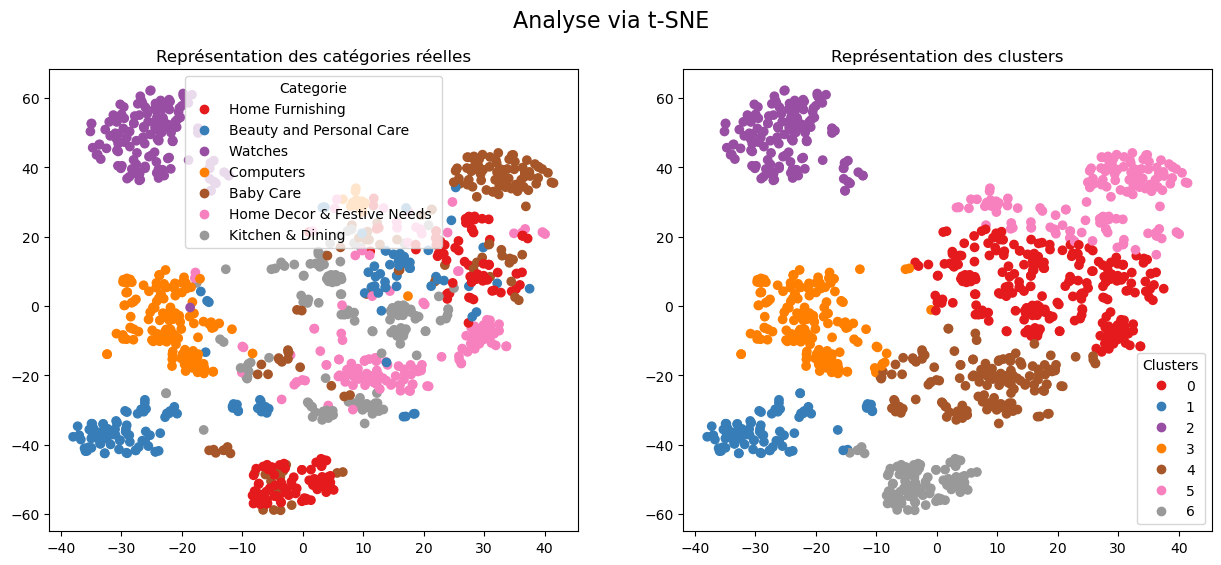

ARI :  0.4375


In [62]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## USE - Universal Sentence Encoder

Universal Sentence Encoder est un modèle de traitement du langage naturel (NLP) développé par Google qui permet d'encoder des phrases en vecteurs de caractéristiques (features) de haute qualité, appelés embeddings. Il s'agit d'un modèle de réseau de neurones profonds, entraîné à grande échelle sur des corpus de textes variés pour apprendre à comprendre la sémantique des phrases.\
Le modèle Universal Sentence Encoder est disponible dans TensorFlow Hub.

In [63]:
#Création d'une fonction pour utiliser USE et transformer les textes en matrice de vecteurs
def feature_USE_fct(sentences, batch_size) :  #on demande une liste de textes et une taille de lot pour la vectorisation
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") #on charge le modèle USE de google

    for i in range(len(sentences)//batch_size) : #pour chaque lot de taille batch_size dans l'ensemble des phrases,
                                                 #soit la division entière du nombre de phrase par la taille de lot
        idx = i*batch_size  #l'index vaut i multiplié par la taille de lot
        feat = embed(sentences[idx:idx+batch_size])  #on fait la vectorisation des indices concernés en lot

        if i ==0 : #si i vaut 0, on initie la matrice
            features = feat
        else :  #si i ne vaut pas 0, on remplit la matrice créée précédemment
            features = np.concatenate((features,feat))
    
    return features # on revoie la matrice

In [64]:
features_USE = feature_USE_fct(sentences_dl, 10)

In [65]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4615 time :  6.0


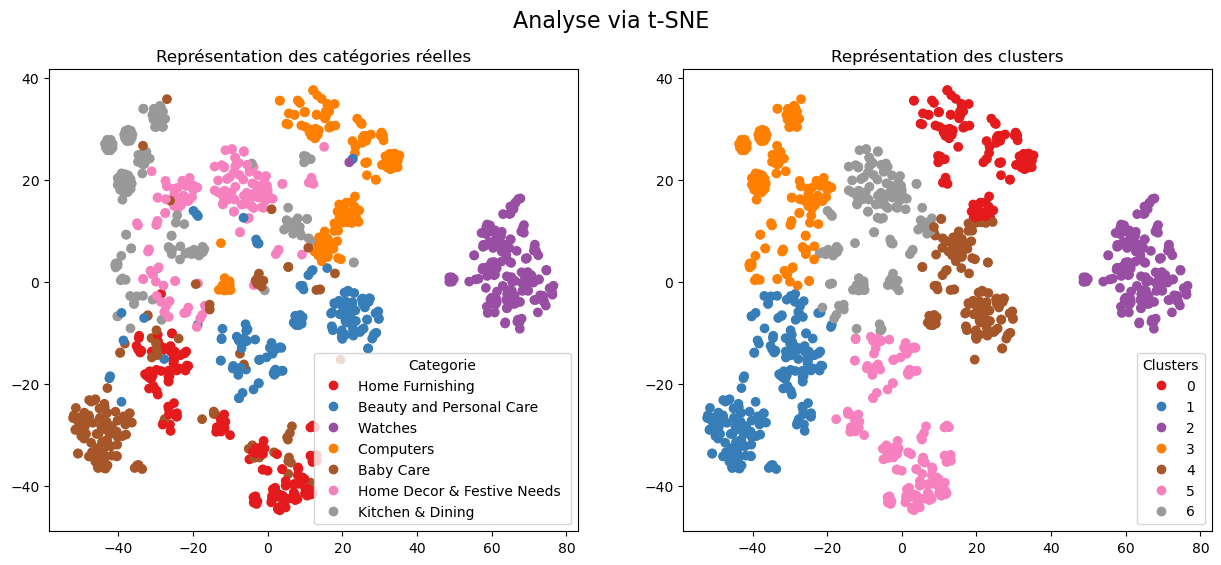

ARI :  0.4615


In [66]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Analyse des images

## SIFT
SIFT, qui signifie Scale-Invariant Feature Transform, est un algorithme de traitement d'image qui permet de détecter et de décrire des caractéristiques uniques d'une image, appelées descripteurs. Les descripteurs SIFT sont utilisés en vision par ordinateur pour la reconnaissance d'objets, la détection de points de correspondance, la création de panoramas d'images et d'autres applications similaires.

Le principal avantage de SIFT est qu'il est invariant aux transformations d'échelle, de rotation et de translation. Cela signifie que les mêmes descripteurs peuvent être trouvés dans une même image, quel que soit l'angle de vue ou la taille de l'objet. En outre, SIFT utilise une méthode appelée « orientation descripteur » pour rendre les descripteurs invariant aux rotations.

Le fonctionnement de SIFT consiste à détecter des points clés, également appelés keypoints, dans l'image, qui sont des points qui ont des structures distinctives, tels que des coins, des bords ou des taches. Ensuite, pour chaque point clé, un descripteur est créé en analysant les gradients de l'image dans une fenêtre autour de ce point clé. Les descripteurs SIFT sont donc des vecteurs qui contiennent des informations sur l'orientation et l'intensité des gradients autour de chaque point clé.

### Import du dataset

In [67]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline
#from os import listdir

path = "./Flipkart/Images/"

### Création des labels des photos à partir du nom des images

In [68]:
from sklearn import preprocessing

#label_name = "no_name"
  
data_image = data_all[{'image','categorie_principale'}].copy()
#le = preprocessing.LabelEncoder()
data_image["label"] = y_cat_num
data_image

/var/folders/6v/t65ymsnx6hd8h__mz5mmp3l80000gn/T/ipykernel_3934/2484179535.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_image = data_all[{'image','categorie_principale'}].copy()


image categorie_principale  label
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg     Home Furnishing       0
1     7b72c92c2f6c40268628ec5f14c6d590.jpg           Baby Care       4
2     64d5d4a258243731dc7bbb1eef49ad74.jpg           Baby Care       4
3     d4684dcdc759dd9cdf41504698d737d8.jpg     Home Furnishing       0
4     6325b6870c54cd47be6ebfbffa620ec7.jpg     Home Furnishing       0
...                                    ...                  ...    ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg           Baby Care       4
1046  fd6cbcc22efb6b761bd564c28928483c.jpg           Baby Care       4
1047  5912e037d12774bb73a2048f35a00009.jpg           Baby Care       4
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg           Baby Care       4
1049  f2f027ad6a6df617c9f125173da71e44.jpg           Baby Care       4

[1050 rows x 3 columns]

In [69]:
data_image.to_csv('data_image.csv', index=False)

In [70]:
data_image.groupby("categorie_principale").count()

image  label
categorie_principale                     
Baby Care                      150    150
Beauty and Personal Care       150    150
Computers                      150    150
Home Decor & Festive Needs     150    150
Home Furnishing                150    150
Kitchen & Dining               150    150
Watches                        150    150

In [71]:
data_image['categorie_principale'].loc[data_image['image']=='189fa66a5fa6f08d2802a62ecf0be298.jpg']

13    Watches 
Name: categorie_principale, dtype: object

### Pré-traitement des images via SIFT
En traitement d'images, un descripteur est une représentation numérique d'une caractéristique particulière d'une image, telle que les coins, les bords ou les textures. Les descripteurs sont utilisés pour comparer des images entre elles, trouver des correspondances entre des images ou détecter des objets dans une image. Dans le cas de la méthode SIFT (Scale-Invariant Feature Transform), les descripteurs sont des vecteurs de 128 dimensions qui représentent les caractéristiques locales d'une image, tels que les points d'intérêt et les orientations locales.

#### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_descriptors") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_descriptors_all") qui sera utilisé pour créer les clusters de descripteurs

In [72]:
# identification of key points and associated descriptors
import time, cv2
sift_descriptors = []
temps1=time.time()
sift = cv2.SIFT_create()
list_photos = data_image["image"]
for image_num in range(len(list_photos)) :
    if image_num%150 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_descriptors.append(des)

sift_descriptors_all = np.concatenate(sift_descriptors, axis=0)

print()
print("Nombre et taille des descripteurs : ", sift_descriptors_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
150
300
450
600
750
900

Nombre et taille des descripteurs :  (9051319, 128)
temps de traitement SIFT descriptor :           269.95 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [73]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_descriptors_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_descriptors_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  3009
Création de 3009 clusters de descripteurs ...


/Users/manuel.martin.67/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :           261.12 secondes


### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [74]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_descriptors) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            57.73 secondes


In [75]:
ARI, X_tsne, labels = ARI_fct(im_features)

ARI :  0.0503 time :  8.0


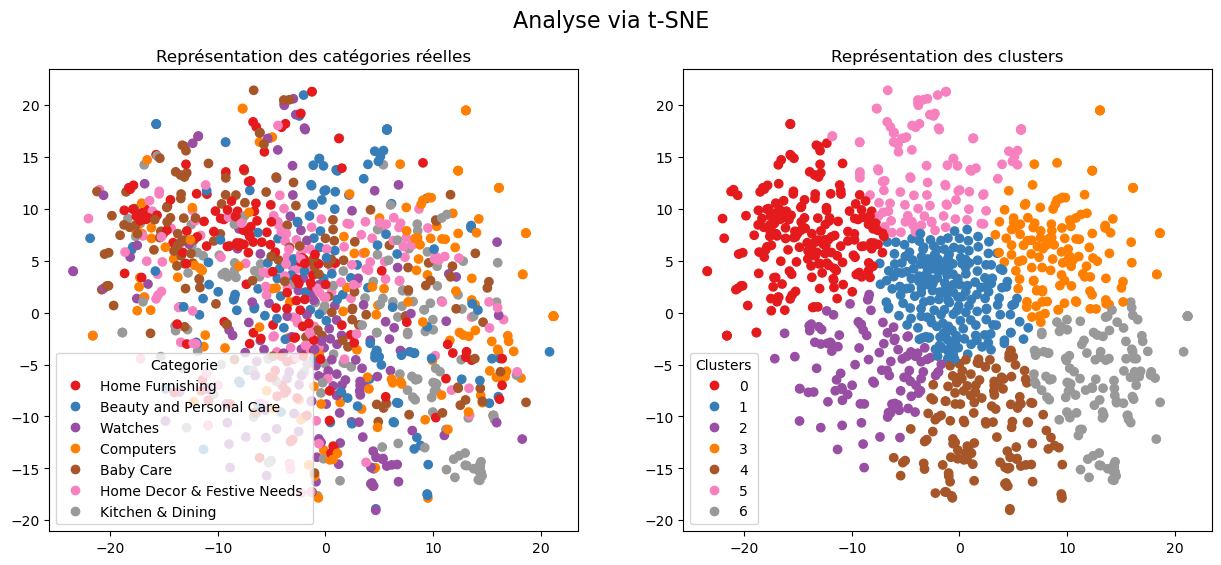

ARI :  0.0503


In [76]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [77]:
from sklearn.decomposition import KernelPCA

# Calcul KernelPCA, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_KernelPCA_fct(features):
    features_df = features.copy()
    time1 = time.time()
    num_labels = len(l_cat)
    
    # application de la KernelPCA
    kpca = KernelPCA(kernel='cosine')
    X_kpca = kpca.fit_transform(features_df)
        
    # Détermination des clusters à partir des données après KernelPCA
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_kpca)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_kpca, cls.labels_

# visualisation du KernelPCA selon les vraies catégories et selon les clusters
def KernelPCA_visu_fct(X_kpca, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Analyse via KernelPCA', fontsize=16)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat,
              loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters')

    plt.show()
    print("ARI : ", ARI)

In [78]:
ARI, X_kpca, labels = ARI_KernelPCA_fct(im_features)

ARI :  0.1 time :  12.0


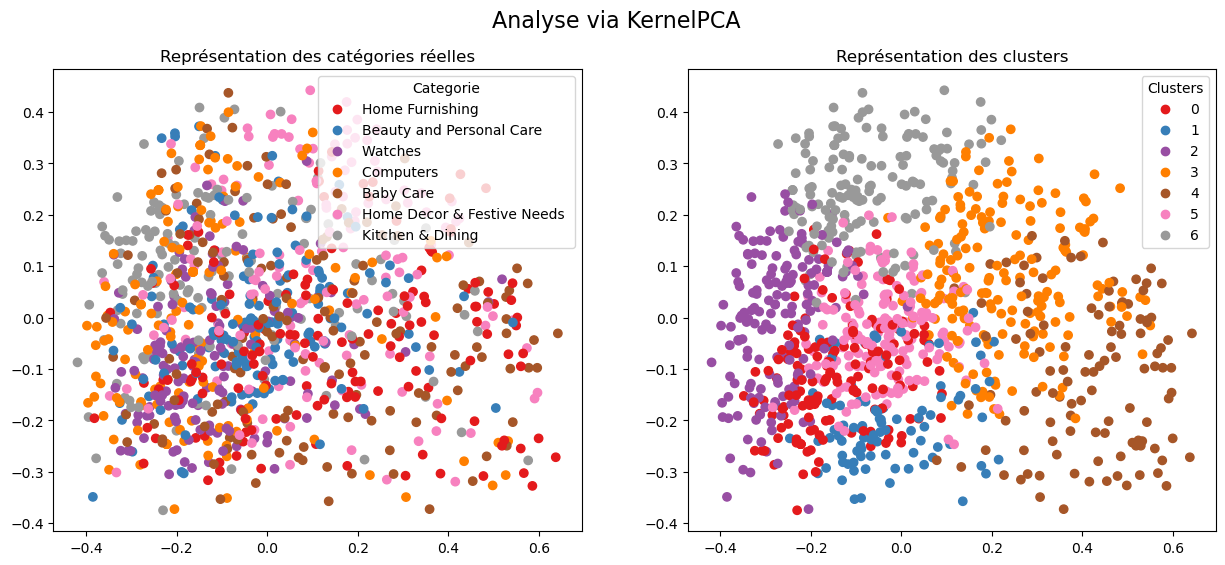

ARI :  0.1


In [79]:
KernelPCA_visu_fct(X_kpca, y_cat_num, labels, ARI)

## Pré-traitement des images via ORB
ORB (Oriented FAST and Rotated BRIEF) est un algorithme de détection et de description de points clés (ou features) similaire à SIFT (Scale-Invariant Feature Transform). Il a été développé pour être plus rapide et plus léger que SIFT tout en produisant des résultats similaires.

ORB combine deux techniques:

FAST (Features from Accelerated Segment Test), une méthode de détection de points clés rapide qui utilise des tests de seuil sur des pixels voisins pour déterminer s'ils sont des points d'intérêt,
BRIEF (Binary Robust Independent Elementary Features), une méthode de description de points clés qui utilise un descripteur binaire court pour représenter chaque point clé détecté.
L'avantage de la méthode BRIEF est qu'elle produit des descripteurs très courts (typiquement 32 à 256 bits) par rapport aux descripteurs SIFT (128 à 512 bits), ce qui permet de gagner en temps de calcul. Cependant, les descripteurs BRIEF ne sont pas invariant à l'échelle ni à la rotation, ce qui est corrigé par l'utilisation de la méthode FAST pour détecter les points clés orientés et la création d'un descripteur ORB basé sur l'orientation.

#### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [80]:
# identification of key points and associated descriptors
import time, cv2
orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create(200)
list_photos = data_image["image"]
for image_num in range(len(list_photos)) :
    if image_num%150 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = orb_keypoints
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
150
300
450
600
750
900

Nombre de descripteurs :  (208903, 32)
temps de traitement ORB descriptor :            30.89 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [81]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  457
Création de 457 clusters de descripteurs ...


/Users/manuel.martin.67/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :             1.30 secondes


### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [82]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.14 secondes


In [83]:
ARI, X_tsne, labels = ARI_fct(im_features)

ARI :  0.0262 time :  6.0


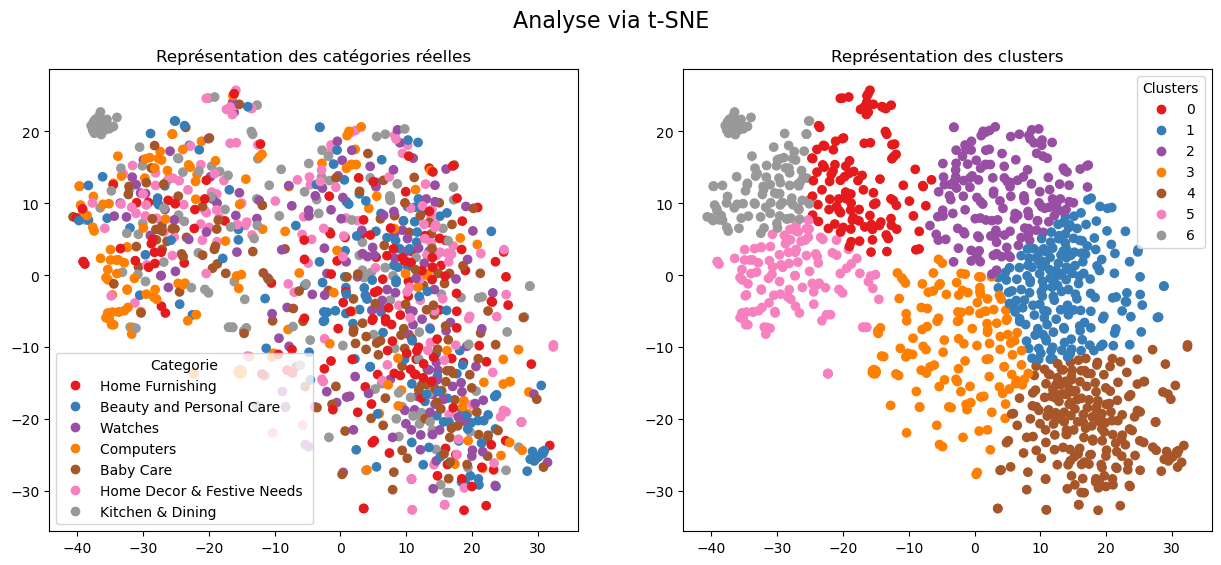

ARI :  0.0262


In [84]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [85]:
from sklearn.decomposition import KernelPCA

# Calcul KernelPCA, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_KernelPCA_fct(features):
    features_df = features.copy()
    time1 = time.time()
    num_labels = len(l_cat)
    
    # application de la KernelPCA
    kpca = KernelPCA(kernel='cosine')
    X_kpca = kpca.fit_transform(features_df)
        
    # Détermination des clusters à partir des données après KernelPCA
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_kpca)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_kpca, cls.labels_

# visualisation du KernelPCA selon les vraies catégories et selon les clusters
def KernelPCA_visu_fct(X_kpca, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Analyse via KernelPCA', fontsize=16)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat,
              loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters')

    plt.show()
    print("ARI : ", ARI)

In [86]:
ARI, X_kpca, labels = ARI_KernelPCA_fct(im_features)

ARI :  0.0288 time :  13.0


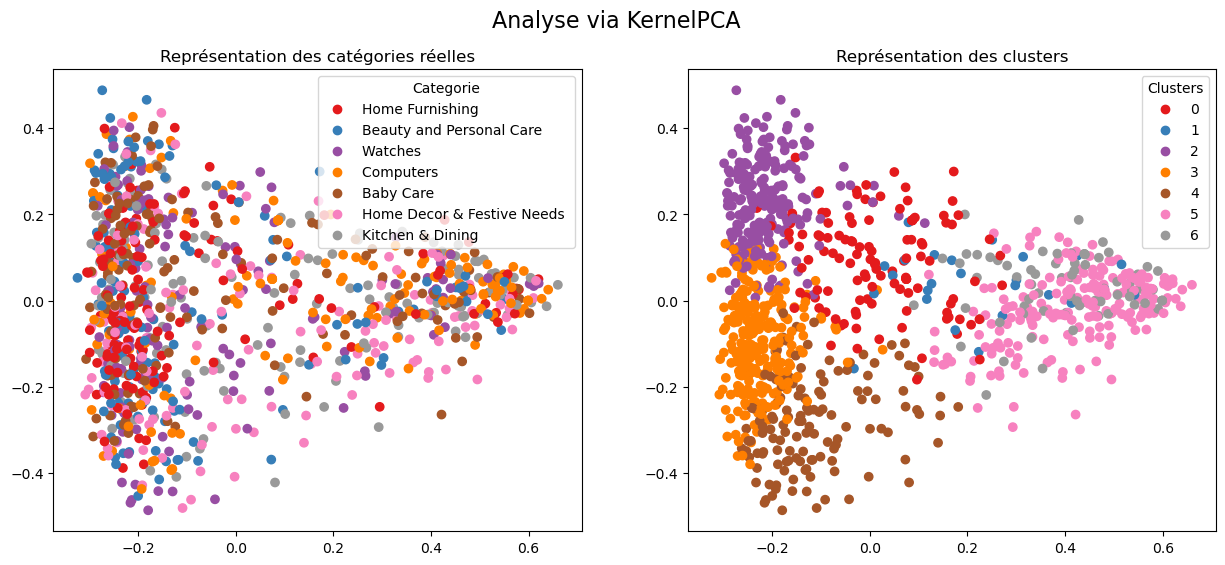

ARI :  0.0288


In [87]:
KernelPCA_visu_fct(X_kpca, y_cat_num, labels, ARI)

## VGG16 sans couche fully connected

In [88]:
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Création du modèle pré-entraîné

In [89]:
# Initialisation d'un modèle de base VGG16 pré-entraîné sur ImageNet
base_model = VGG16()
# Extraction du modèle de base pour récupérer les couches jusqu'à l'avant-dernière couche
# Ceci est utile pour la réutilisation de la base de convolution du modèle VGG16
# pour l'entraînement d'un modèle de classification
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-4].output)
# Affichage d'un résumé de la structure du modèle personnalisé, qui montre toutes les couches du modèle
# ainsi que le nombre de paramètres entraînables dans chaque couche
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Création des features des images

In [90]:
# Création d'une liste vide pour stocker les vecteurs de caractéristiques des images
images_features = []

# Initialisation du compteur d'itérations
i = 0 

# Boucle sur chaque fichier d'image dans le chemin spécifié
for image_file in (path + data_image["image"]) :

    # Affichage du nombre d'images traitées toutes les 100 images
    if i % 100 == 0:
        print(i)

    # Chargement de l'image avec la taille cible de (224, 224)
    image = load_img(image_file, target_size=(224, 224))

    # Conversion de l'image en un tableau numpy
    image = img_to_array(image) 

    # Ajout d'une dimension pour représenter le batch d'images
    image = np.expand_dims(image, axis=0)

    # Prétraitement de l'image pour la normaliser selon la méthode utilisée pour entraîner le modèle VGG16
    image = preprocess_input(image)

    # Extraction des vecteurs de caractéristiques de l'image à l'aide du modèle VGG16 pré-entraîné
    # Le paramètre verbose est défini sur 0 pour éviter l'affichage des informations de progression lors de la prédiction
    images_features.append(model.predict(image, verbose=0)[0])

    # Incrémentation du compteur d'itérations
    i += 1

# Conversion de la liste des vecteurs de caractéristiques en un tableau numpy
images_features = np.asarray(images_features)

# Affichage de la forme du tableau numpy
print(images_features.shape)

0
100
200
300
400
500
600


/Users/manuel.martin.67/anaconda3/envs/tf/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 25088)


In [91]:
ARI, X_tsne, labels = ARI_fct(images_features)

ARI :  0.3109 time :  8.0


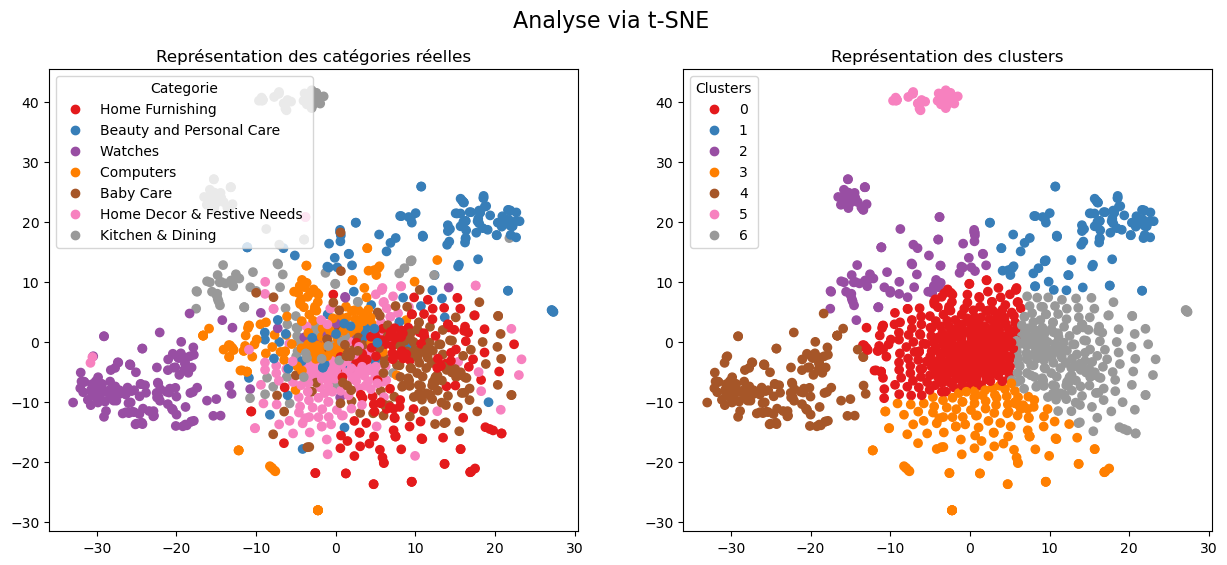

ARI :  0.3109


In [92]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## VGG16 avec 2 couches fully connected

In [93]:
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Création du modèle pré-entraîné

In [94]:
# Initialisation d'un modèle de base VGG16 pré-entraîné sur ImageNet
base_model = VGG16()
# Extraction du modèle de base pour récupérer les couches jusqu'à l'avant-dernière couche
# Ceci est utile pour la réutilisation de la base de convolution du modèle VGG16
# pour l'entraînement d'un modèle de classification
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
# Affichage d'un résumé de la structure du modèle personnalisé, qui montre toutes les couches du modèle
# ainsi que le nombre de paramètres entraînables dans chaque couche
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Création des features des images

In [95]:
# Création d'une liste vide pour stocker les vecteurs de caractéristiques des images
images_features = []

# Initialisation du compteur d'itérations
i = 0 

# Boucle sur chaque fichier d'image dans le chemin spécifié
for image_file in (path + data_image["image"]) :

    # Affichage du nombre d'images traitées toutes les 100 images
    if i % 100 == 0:
        print(i)

    # Chargement de l'image avec la taille cible de (224, 224)
    image = load_img(image_file, target_size=(224, 224))

    # Conversion de l'image en un tableau numpy
    image = img_to_array(image) 

    # Ajout d'une dimension pour représenter le batch d'images
    image = np.expand_dims(image, axis=0)

    # Prétraitement de l'image pour la normaliser selon la méthode utilisée pour entraîner le modèle VGG16
    image = preprocess_input(image)

    # Extraction des vecteurs de caractéristiques de l'image à l'aide du modèle VGG16 pré-entraîné
    # Le paramètre verbose est défini sur 0 pour éviter l'affichage des informations de progression lors de la prédiction
    images_features.append(model.predict(image, verbose=0)[0])

    # Incrémentation du compteur d'itérations
    i += 1

# Conversion de la liste des vecteurs de caractéristiques en un tableau numpy
images_features = np.asarray(images_features)

# Affichage de la forme du tableau numpy
print(images_features.shape)

0
100
200
300
400
500
600


/Users/manuel.martin.67/anaconda3/envs/tf/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 4096)


In [96]:
ARI, X_tsne, labels = ARI_fct(images_features)

ARI :  0.5157 time :  6.0


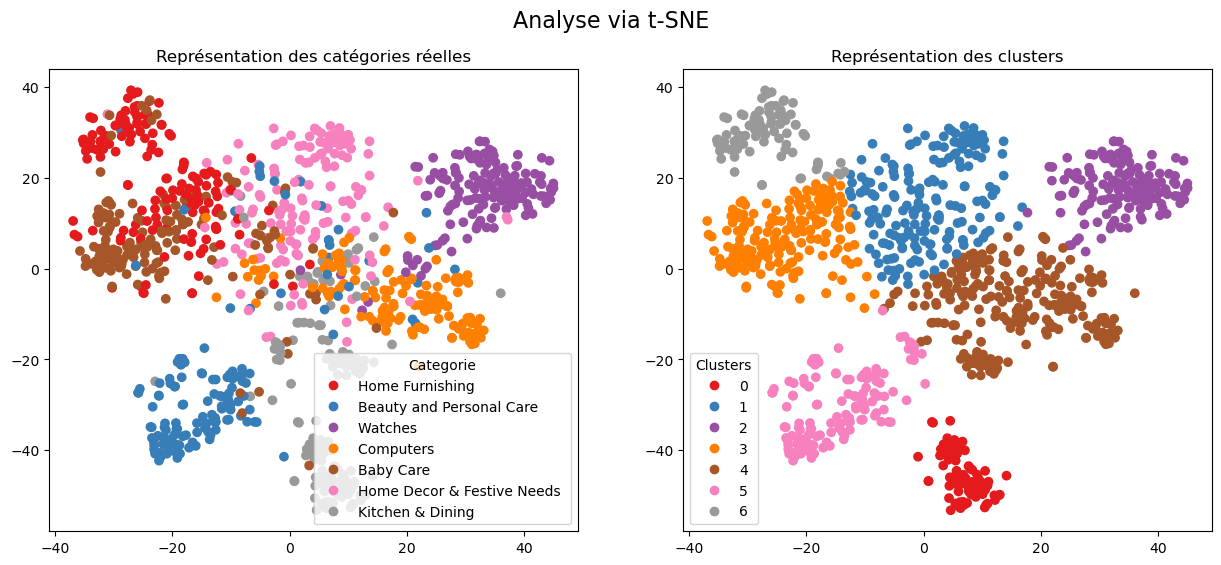

ARI :  0.5157


In [97]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Groupage feature textuelle et visuelle

In [98]:
ctf_transform_dataframe = pd.DataFrame.sparse.from_spmatrix(ctf_transform)
ctf_transform_df = ctf_transform_dataframe.copy()
ctf_transform_df['image'] = data_all['image']

In [99]:
images_features_df = pd.DataFrame(images_features)
images_features_df['image'] = data_image['image']

In [100]:
ARI, X_tsne_text, labels = ARI_fct(ctf_transform)
ARI, X_tsne_image, labels = ARI_fct(images_features)
X_tsne_global = np.concatenate((X_tsne_text, X_tsne_image), axis=1)
ARI, X_tsne_glob, labels = ARI_fct(X_tsne_global)

ARI :  0.6023 time :  6.0
ARI :  0.5157 time :  6.0
ARI :  0.6321 time :  5.0


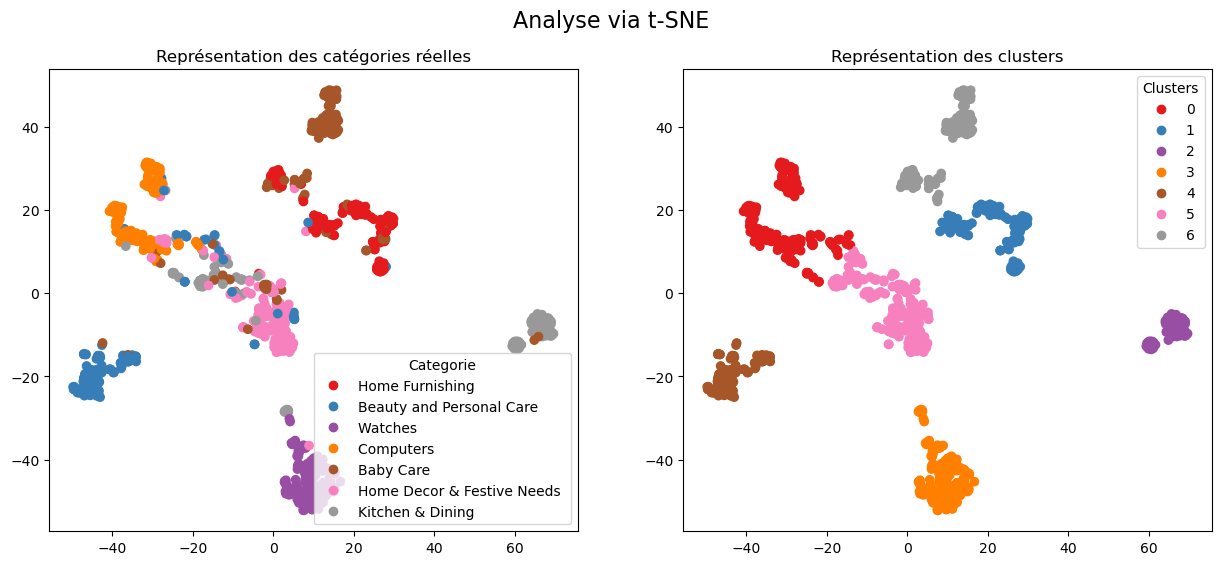

ARI :  0.6321


In [101]:
TSNE_visu_fct(X_tsne_glob, y_cat_num, labels, ARI)